# Getting Started

In [ ]:
!pip install -Uqq pycaret
!pip install -Uqq optuna
!pip install -Uqq shap
!pip install -Uqq catboost
!pip install -Uqq lightgbm
!pip install -Uqq autogluon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 13.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.0 MB/s

In [ ]:
import os, optuna, shap
import pandas as pd
import numpy as np
import missingno as msno
from tqdm.auto import tqdm
from scipy.stats.mstats import winsorize
from scipy.stats import boxcox
from sklearn.model_selection import KFold, train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from pycaret.classification import *

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, power_transform

# REMOVE WARNINGS
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
train_features = pd.read_csv('/content/gdrive/MyDrive/findit-ugm24/train_features.csv')
train_labels = pd.read_csv('/content/gdrive/MyDrive/findit-ugm24/train_labels.csv')

train = pd.concat([train_features, train_labels], axis=1)
test = pd.read_csv('/content/gdrive/MyDrive/findit-ugm24/test_features.csv')

In [ ]:
train.head(3)

,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota,jumlah_promosi
0,1979,Sarjana,Rencana Menikah,NaN,0.0,1.0,NaN,50575.0,260967.0,50575.0,20230.0,2.0,2.0,5.0,0.0,2014-05-05,2
1,1950,Sarjana,Rencana Menikah,84063000.0,NaN,NaN,70.0,6069.0,44506.0,80920.0,20230.0,9.0,6.0,4.0,0.0,2013-03-17,0
2,1966,Sarjana,Menikah,127532564.0,0.0,0.0,45.0,117611.0,265460.0,96341.0,145573.0,1.0,1.0,7.0,0.0,NaN,1


In [ ]:
test.head(3)

,ID,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota
0,2241,1957,Sarjana,NaN,120660151.0,0.0,1.0,63.0,122277.0,541399.0,214192.0,84305.0,4.0,6.0,10.0,0.0,NaN
1,2274,1968,Doktor,Menikah,163551821.0,0.0,1.0,58.0,35761.0,353335.0,63365.0,41112.0,2.0,5.0,10.0,0.0,NaN
2,1107,1968,SMA,Menikah,29857000.0,0.0,0.0,34.0,8092.0,22253.0,30345.0,26299.0,2.0,0.0,5.0,0.0,2013-08-06


# Exploratory Data Analysis (EDA)

## Missing Values

<Axes: >

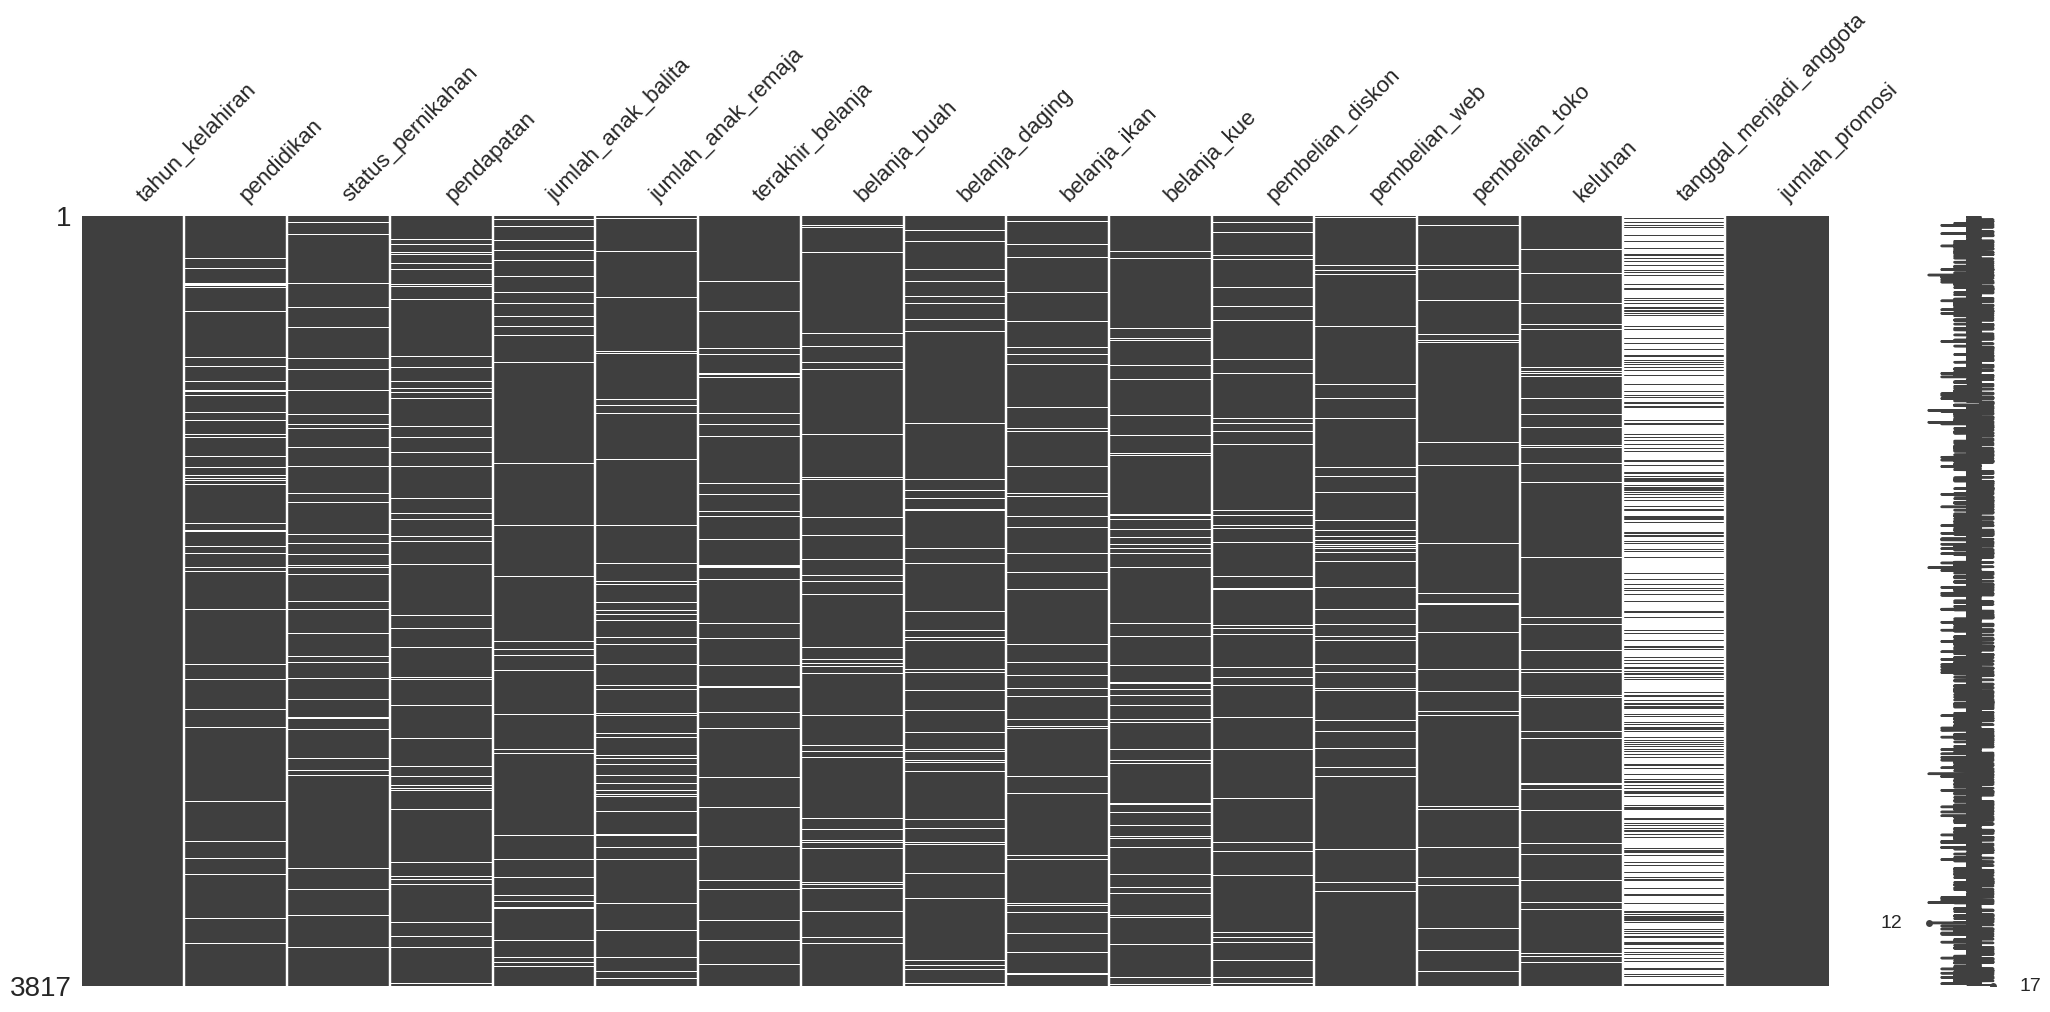

In [ ]:
msno.matrix(train)

<Axes: >

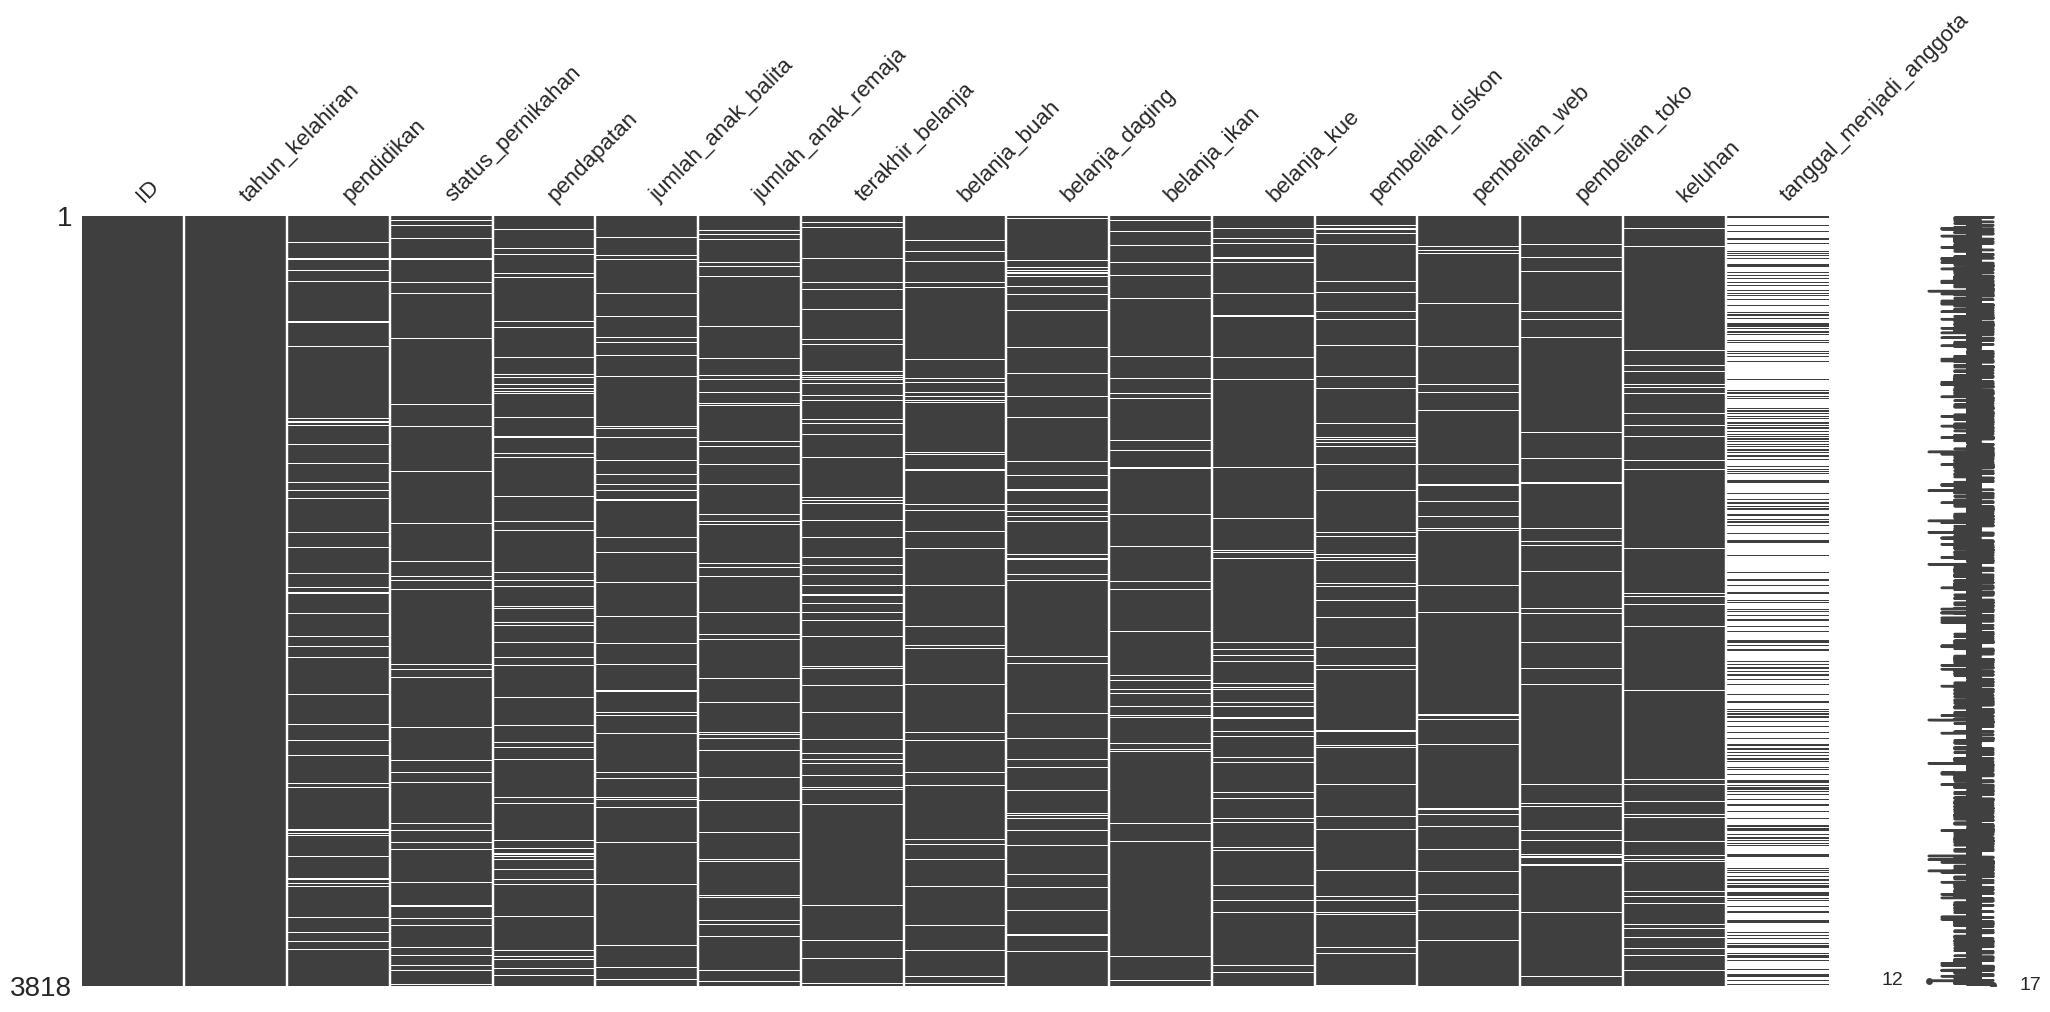

In [ ]:
msno.matrix(test)

## Continuous Distributions

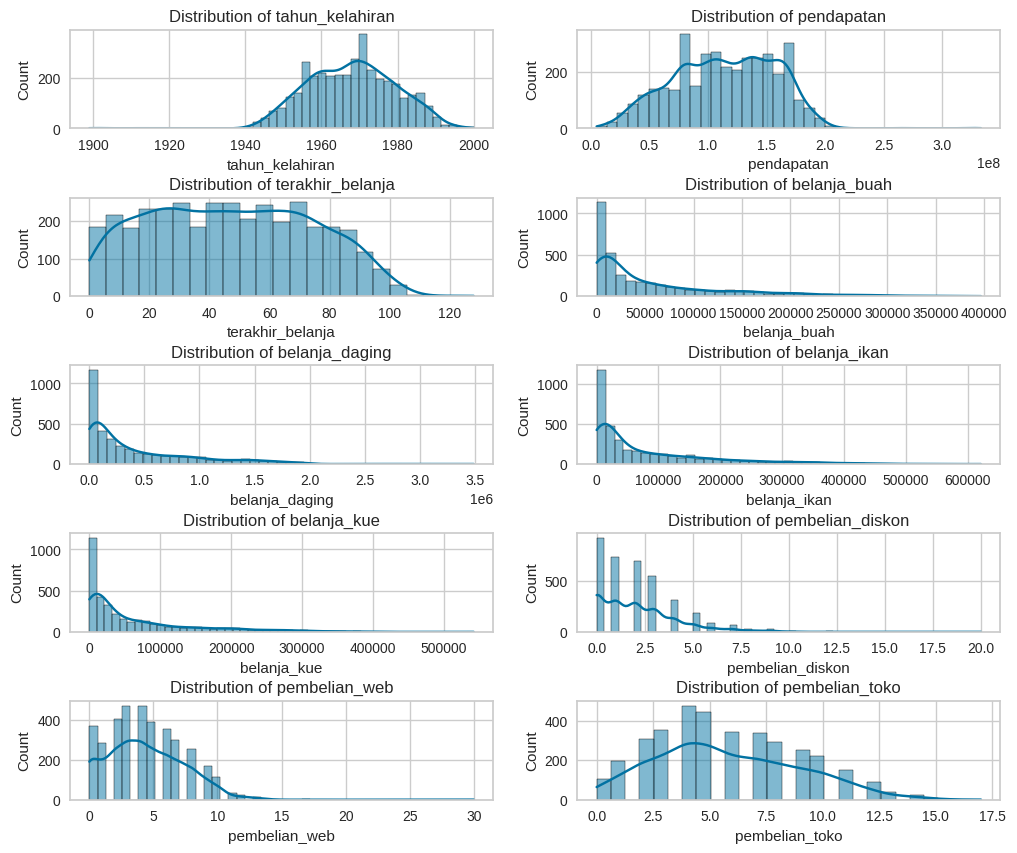

In [ ]:
continuous_cols = ['tahun_kelahiran', 'pendapatan', 'terakhir_belanja', 'belanja_buah', 'belanja_daging', 'belanja_ikan', 'belanja_kue', 'pembelian_diskon']

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(12, 10))
for i, col in enumerate(continuous_cols):
    sns.histplot(train[col], ax=axs[i//2, i%2], kde=True)
    axs[i//2, i%2].set_title(f'Distribution of {col}')
    axs[i//2, i%2].set_xlabel(col)

plt.subplots_adjust(wspace=0.2, hspace=0.7)
plt.show()

## Discrete Distributions

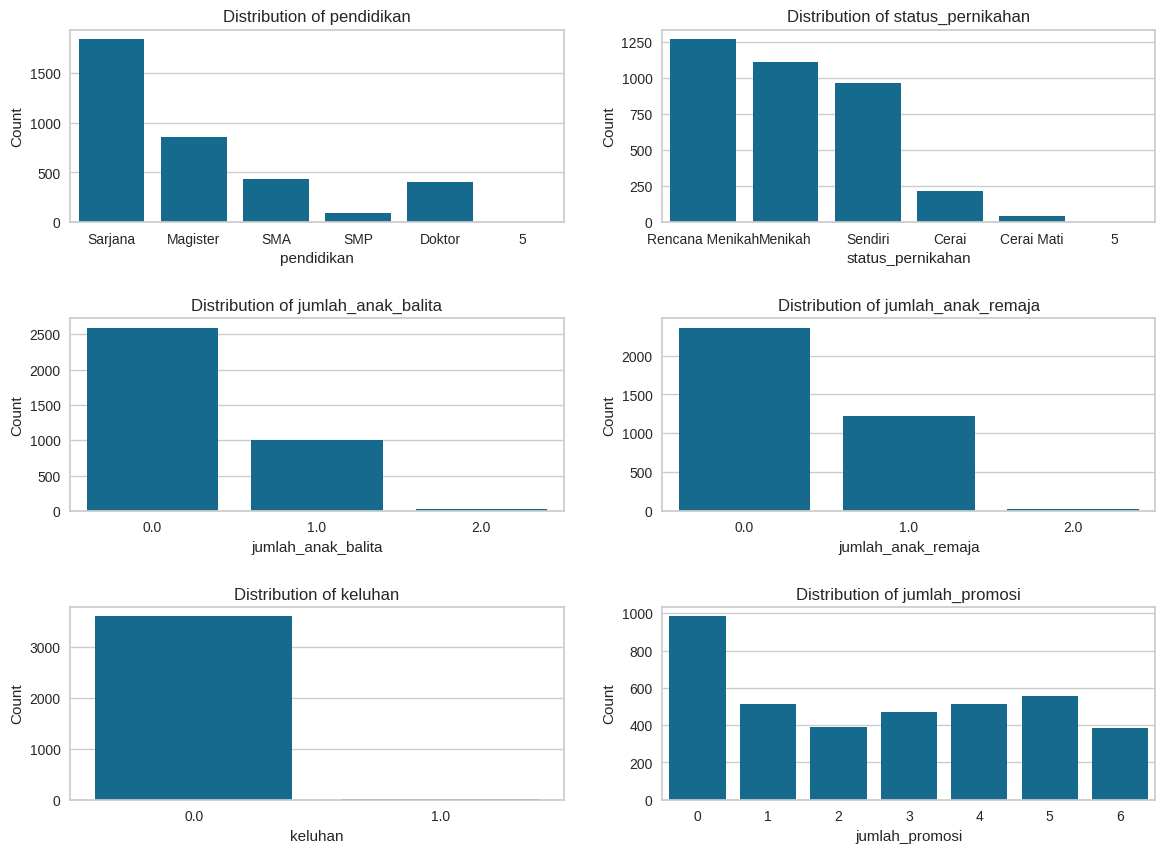

In [ ]:
discrete_cols = ['pendidikan', 'status_pernikahan', 'jumlah_anak_balita', 'jumlah_anak_remaja', 'keluhan', 'jumlah_promosi', 'pembelian_web', 'pembelian_toko']

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(14, 10))
for i, col in enumerate(discrete_cols):
    sns.countplot(data=train, x=col, ax=axs[i//2, i%2])
    axs[i//2, i%2].set_title(f'Distribution of {col}')
    axs[i//2, i%2].set_xlabel(col)
    axs[i//2, i%2].set_ylabel('Count')

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

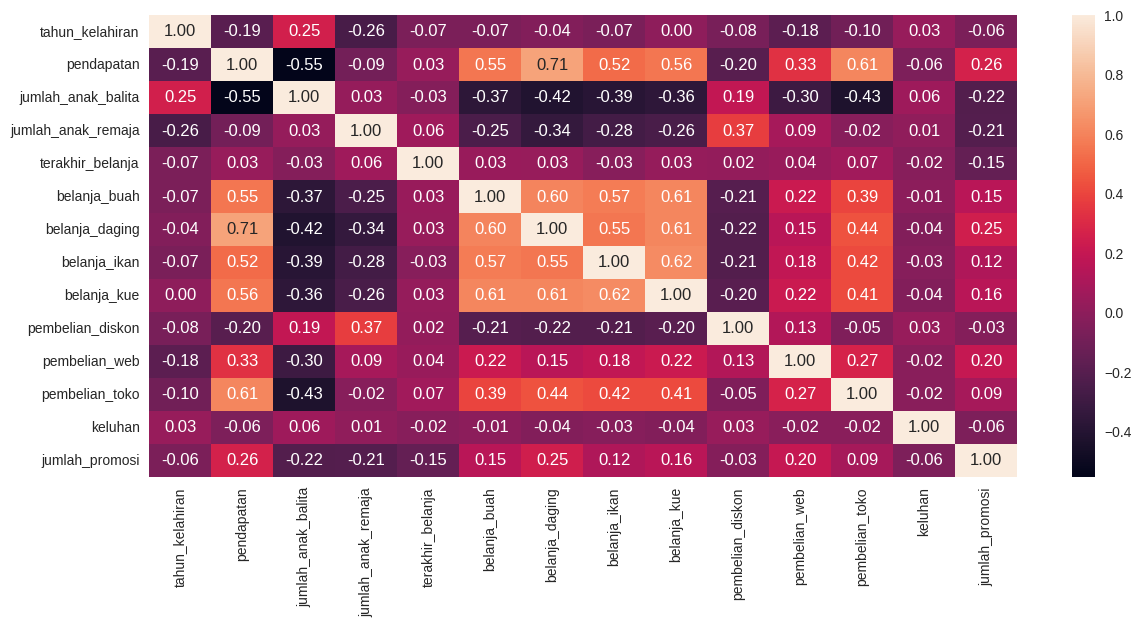

In [ ]:
numerical_cols = train.select_dtypes(include=['float64', 'int64']).columns.tolist()
correlation = train[numerical_cols].corr()

plt.figure(figsize=(14, 6))
sns.heatmap(correlation, annot=True, fmt='.2f')
plt.show()

# Preprocessing

In [ ]:
# fitur 'pendidikan'
train['pendidikan'] = train['pendidikan'].replace('5', 'Sarjana')
test['pendidikan'] = test['pendidikan'].replace('5', 'Sarjana')
train['pendidikan'] = train['pendidikan'].fillna(train['pendidikan'].mode()[0])
test['pendidikan'] = test['pendidikan'].fillna(train['pendidikan'].mode()[0])

In [ ]:
# fitur 'status_pernikahan'
train['status_pernikahan'] = train['status_pernikahan'].replace('5', train['status_pernikahan'].mode()[0])
test['status_pernikahan'] = test['status_pernikahan'].replace('5', train['status_pernikahan'].mode()[0])
train['status_pernikahan'] = train['status_pernikahan'].fillna(train['status_pernikahan'].mode()[0])
test['status_pernikahan'] = test['status_pernikahan'].fillna(train['status_pernikahan'].mode()[0])

In [ ]:
# fitur 'pendapatan', 'belanja_buah', 'belanja_daging', 'belanja_ikan', 'belanja_kue', 'pembelian_toko', 'jumlah_anak_balita'
# IDEA : impute missing values with highly correlated features using IterativeImputer
cols = ['pendapatan', 'belanja_buah', 'belanja_daging', 'belanja_ikan', 'belanja_kue', 'pembelian_toko', 'jumlah_anak_balita']

imputer = IterativeImputer(imputation_order='descending') # default BayesianRidge()
imputed_data_train = pd.DataFrame(imputer.fit_transform(train[cols]), columns=cols, index=train.index)
train = train.drop(cols, axis=1)
train = pd.concat([train, imputed_data_train], axis=1)

imputed_data_test = pd.DataFrame(imputer.fit_transform(test[cols]), columns=cols, index=test.index)
test = test.drop(cols, axis=1)
test = pd.concat([test, imputed_data_test], axis=1)

In [ ]:
# cols = ['pendapatan', 'belanja_buah', 'belanja_daging', 'belanja_ikan', 'belanja_kue', 'pembelian_toko', 'jumlah_anak_balita']

# for col in cols:
#   train[col] = train[col].fillna(train[col].median())
#   test[col] = test[col].fillna(train[col].median())

In [ ]:
# fitur 'jumlah_anak_remaja', 'terakhir_belanja'
train['jumlah_anak_remaja'] = train['jumlah_anak_remaja'].fillna(train['jumlah_anak_remaja'].median())
train['terakhir_belanja'] = train['terakhir_belanja'].fillna(train['terakhir_belanja'].median())

test['jumlah_anak_remaja'] = test['jumlah_anak_remaja'].fillna(train['jumlah_anak_remaja'].median())
test['terakhir_belanja'] = test['terakhir_belanja'].fillna(train['terakhir_belanja'].median())

In [ ]:
# fitur 'pembelian diskon', 'pembelian web', 'keluhan'
train['pembelian_diskon'] = train['pembelian_diskon'].fillna(train['pembelian_diskon'].mode()[0])
train['pembelian_web'] = train['pembelian_web'].fillna(train['pembelian_web'].mode()[0])
# train['keluhan'] = train['keluhan'].fillna(train['keluhan'].mode()[0])
train = train.drop('keluhan', axis=1)

test['pembelian_diskon'] = test['pembelian_diskon'].fillna(train['pembelian_diskon'].mode()[0])
test['pembelian_web'] = test['pembelian_web'].fillna(train['pembelian_web'].mode()[0])
test['keluhan'] = test['keluhan'].fillna(train['keluhan'].mode()[0])
test = test.drop('keluhan', axis=1)

In [ ]:
# fitur 'tanggal_menjadi_anggota
train['tanggal_menjadi_anggota'] = pd.to_datetime(train['tanggal_menjadi_anggota'])
train.drop('tanggal_menjadi_anggota', axis=1, inplace=True)

test['tanggal_menjadi_anggota'] = pd.to_datetime(test['tanggal_menjadi_anggota'])
test.drop('tanggal_menjadi_anggota', axis=1, inplace=True)

In [ ]:
# encoding 'pendidikan', 'status_pernikahan'
pendidikan_map = {
    'SMP': 1,
    'SMA': 2,
    'Sarjana': 3,
    'Magister': 4,
    'Doktor': 5
}
train['pendidikan'] = train['pendidikan'].map(pendidikan_map)
one_hot = pd.get_dummies(train['status_pernikahan'], dtype=int)
train = train.drop('status_pernikahan', axis=1)
train = pd.concat([train, one_hot], axis=1)

test['pendidikan'] = test['pendidikan'].map(pendidikan_map)
one_hot = pd.get_dummies(test['status_pernikahan'], dtype=int)
test = test.drop('status_pernikahan', axis=1)
test = pd.concat([test, one_hot], axis=1)

In [ ]:
skewed_cols = ['belanja_buah', 'belanja_daging', 'belanja_ikan', 'belanja_kue']

# change skewed columns negative values to zero
train[train[skewed_cols] < 0] = 0
# add one
train[skewed_cols] = train[skewed_cols] + 1

# boxcox transformation
for cols in skewed_cols:
  transformed_col = power_transform(train[[cols]], method='box-cox')
  transformed_col = pd.DataFrame(transformed_col, columns=[cols])

  train = train.drop(cols, axis=1)
  train = pd.concat([train, transformed_col], axis=1)

In [ ]:
# change skewed columns negative values to zero
test[test[skewed_cols] < 0] = 0
# add one
test[skewed_cols] = test[skewed_cols] + 1

# boxcox transformation
for cols in skewed_cols:
  transformed_col = power_transform(test[[cols]], method='box-cox')
  transformed_col = pd.DataFrame(transformed_col, columns=[cols])

  test = test.drop(cols, axis=1)
  test = pd.concat([test, transformed_col], axis=1)

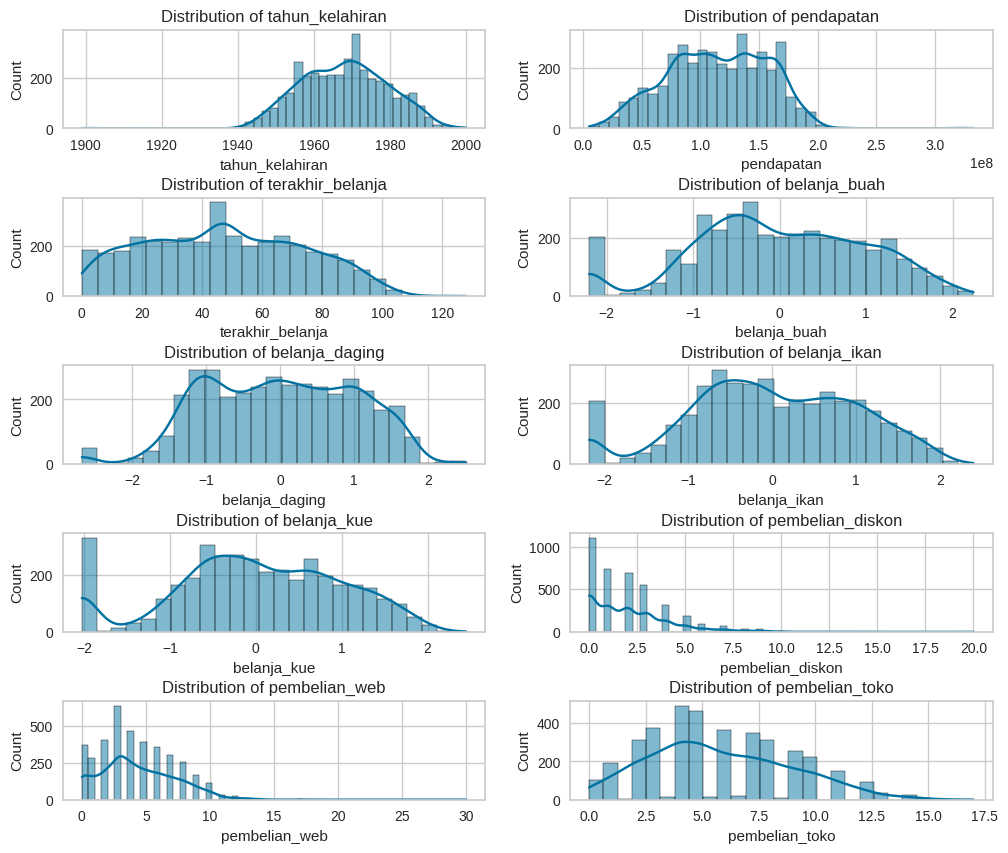

In [ ]:
continuous_cols = ['tahun_kelahiran', 'pendapatan', 'terakhir_belanja', 'belanja_buah', 'belanja_daging', 'belanja_ikan', 'belanja_kue', 'pembelian_diskon', 'pembelian_web', 'pembelian_toko']

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(12, 10))
for i, col in enumerate(continuous_cols):
    sns.histplot(train[col], ax=axs[i//2, i%2], kde=True)
    axs[i//2, i%2].set_title(f'Distribution of {col}')
    axs[i//2, i%2].set_xlabel(col)

plt.subplots_adjust(wspace=0.2, hspace=0.7)
plt.show()

# Modeling

## PyCaret Experiment

In [ ]:
# s = setup(train, target='jumlah_promosi')

In [ ]:
# best = compare_models()

## Gradient Boosting Models

In [ ]:
X = train.drop('jumlah_promosi', axis=1)
y = train['jumlah_promosi']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=12)

In [ ]:
def kfold_indices(data, k):
    fold_size = len(data) // k
    indices = np.arange(len(data))
    folds = []
    for i in range(k):
        test_indices = indices[i * fold_size: (i + 1) * fold_size]
        train_indices = np.concatenate([indices[:i * fold_size], indices[(i + 1) * fold_size:]])
        folds.append((train_indices, test_indices))
    return folds

k = 5
# it contains list of index of train data
fold_indices = kfold_indices(train, k)

In [ ]:
def cross_validation(model_name, model, X, y, fold_indices):
    scores = []
    for train_indices, test_indices in fold_indices:
        X_train, y_train = X[X.index.isin(train_indices)], y[X.index.isin(train_indices)]
        X_val, y_val = X[X.index.isin(test_indices)], y[X.index.isin(test_indices)]
        # train the model
        model.fit(X_train, y_train)
        # create prediction
        y_pred = model.predict(X_val)
        # f1 score for this fold
        fold_score = f1_score(y_val, y_pred, average='macro')
        scores.append(fold_score)

    # Calculate the mean accuracy across all folds
    mean_accuracy = np.mean(scores)
    print(model_name.upper())
    print(f"K-Fold Cross-Validation Scores:\n{scores}")
    print(f"Mean F1 Score: {mean_accuracy}")

In [ ]:
# xgb_model = XGBClassifier()
# cb_model = CatBoostClassifier(verbose=False)
# lgb_model = LGBMClassifier(verbose=0)

In [ ]:
# cross_validation('xgb classifier', xgb_model, X, y, fold_indices)

XGB CLASSIFIER
K-Fold Cross-Validation Scores:
[0.7086231710243742, 0.7019189570800934, 0.7112921810333681, 0.7188280978920137, 0.7279020800450694]
Mean F1 Score: 0.7137128974149839


In [ ]:
# cross_validation('catboost classifier', cb_model, X, y, fold_indices)

CATBOOST CLASSIFIER
K-Fold Cross-Validation Scores:
[0.7097897813718322, 0.705534464779762, 0.6819180482111931, 0.7054576555825213, 0.7209505818184896]
Mean F1 Score: 0.7047301063527596


In [ ]:
# cross_validation('lgbm classifier', lgb_model, X, y, fold_indices)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
LGBM CLASSIFIER
K-Fold Cross-Validation Scores:
[0.7227998970489071, 0.7104859094119444, 0.7105278701675901, 0.7365915150613702, 0.721440796335194]
Mean F1 Score: 0.7203691976050013


## AutoGluon

In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor

train_autogluon, test_autogluon = train_test_split(train, test_size=0.2, random_state=42)

train_autogluon = TabularDataset(train_autogluon)
train_autogluon.head(3)

,tahun_kelahiran,pendidikan,jumlah_anak_remaja,terakhir_belanja,pembelian_diskon,pembelian_web,keluhan,jumlah_promosi,pendapatan,pembelian_toko,jumlah_anak_balita,Cerai,Cerai Mati,Menikah,Rencana Menikah,Sendiri,belanja_buah,belanja_daging,belanja_ikan,belanja_kue
700,1957,3,1.0,64.0,5.0,3.0,0.0,4,1.113185e+08,7.0,0.000000,0,0,0,1,0,0.046165,-0.000644,-0.429654,-1.068292
2044,1979,3,0.0,12.0,0.0,3.0,0.0,1,8.682721e+07,2.0,0.000000,0,0,0,1,0,-0.248130,-1.407789,-1.258322,-0.094227
644,1952,5,0.0,27.0,2.0,4.0,0.0,3,1.709433e+08,10.0,-0.071831,1,0,0,0,0,0.850353,1.273020,0.926124,1.335370


In [ ]:
predictor = TabularPredictor(label='jumlah_promosi', path='agModels-predictClassv4', eval_metric='f1_macro').fit(
    train_autogluon,
    presets='best_quality',
    auto_stack=True,
    time_limit=300
)

Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 300 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: agModels-predictClassv4/ds_sub_fit/sub_fit_ho.
Running the sub-fit in a ray process to avoid memory leakage.
Spend 194 seconds for the sub-fit(s) during dynamic stacking.
Time left for full fit of AutoGluon: 106 second

In [ ]:
predictor = TabularPredictor.load("agModels-predictClassv4")

In [ ]:
predictor.leaderboard(test_autogluon)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,0.647403,0.641198,f1_macro,0.673758,0.701461,144.952452,0.003800,0.006509,0.586411,3,True,6
1,WeightedEnsemble_L2,0.645646,0.626974,f1_macro,0.373358,0.434075,83.973082,0.004867,0.006385,0.419189,2,True,4
2,NeuralNetFastAI_BAG_L2,0.644918,0.640265,f1_macro,0.669958,0.694952,144.366041,0.301467,0.267262,60.812149,2,True,5
3,NeuralNetFastAI_BAG_L1,0.617897,0.610663,f1_macro,0.316741,0.354086,83.519006,0.316741,0.354086,83.519006,1,True,3
4,KNeighborsUnif_BAG_L1,0.380426,0.390293,f1_macro,0.026097,0.038338,0.018396,0.026097,0.038338,0.018396,1,True,1
5,KNeighborsDist_BAG_L1,0.370505,0.380711,f1_macro,0.025654,0.035265,0.016491,0.025654,0.035265,0.016491,1,True,2


# Submission

In [ ]:
predictions = pd.DataFrame({
    'ID': test['ID'],
    'jumlah_promosi': lgb_model.predict(test.drop('ID', axis=1))
})
predictions.head()

,ID,jumlah_promosi
0,2241,1
1,2274,0
2,1107,0
3,4478,3
4,5080,4


In [ ]:
# predictions.to_csv('submissionv1.csv', index=False)

In [ ]:
# Define feature engineering function
def engineer_features(group):
    group['per_capita_gdp'] = group['gross_regional_domestic_product'] / group['population']
    group['waste_per_capita'] = group['solid_waste_generated'] / group['population']
    group['green_space_per_capita'] = group['green_open_space'] / group['population']
    group['green_space_ratio'] = group['green_open_space'] / group['total_area (km2)']
    group['population_to_green_ratio'] = group['population'] / group['green_open_space']
    group['economic_density'] = group['gross_regional_domestic_product'] / group['total_area (km2)']
    group['landfill_density'] = group['total_landfills'] / group['total_area (km2)']
    group['waste_to_landfill_ratio'] = group['solid_waste_generated'] / group['total_landfills']
    group['hdi_density_adjusted'] = group['hdi'] / group['densities']
    return group

# Apply features to each group
grouped_df = train.groupby('province_year').apply(engineer_features)

# Merge back to the original DataFrame
train = train.merge(grouped_df.drop(['province', 'year'], axis=1), on='province_year', how='left')